This notebook performs response-weighted analysis on the activation outputs of the Jaco model trained with domain randomisation.

# Initialisation

In [31]:
from rwa_functions import *  # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [32]:
# Define the network - returns the activation maps as outputs
class Network(nn.Module):
    def __init__(self, non_rgb_state_size, num_actions, hidden_size, init_weight_normal, visual_only=False):
        super(Network, self).__init__()
        # Define a flag
        self.visual_only = visual_only
        # Define the conv network
        self.conv1 = nn.Conv2d(3, 16, 8, stride=4, padding=1) # 3 input channels, 16 output channels, 8x8 kernel, stride 4
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2) # 16 input channels, 32 output channels, 5x5 kernel, stride 2
        if self.visual_only:
            self.fc1 = nn.Linear(1152, hidden_size)
        else:
            self.fc1 = nn.Linear(1152 + non_rgb_state_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        # define the network to output the policy
        self.fc_actor1 = nn.Linear(hidden_size, num_actions)
        self.fc_actor2 = nn.Linear(hidden_size, num_actions)
        self.fc_actor3 = nn.Linear(hidden_size, num_actions)
        self.fc_actor4 = nn.Linear(hidden_size, num_actions)
        self.fc_actor5 = nn.Linear(hidden_size, num_actions)
        self.fc_actor6 = nn.Linear(hidden_size, num_actions)
        # define the network to output the value
        self.critic_value = nn.Linear(hidden_size, 1)
        # orthogonal weight initialisation
        for name, p in self.named_parameters():
            if 'weight' in name:
                if init_weight_normal:
                    fan_in, _ = init._calculate_fan_in_and_fan_out(p)
                    std = 1 / math.sqrt(fan_in)
                    init.normal_(p, std=std)
                else:
                    init.orthogonal_(p)
            elif 'bias' in name:
                init.constant_(p, 0)
    
    # define the forward function
    def forward(self, non_rgb_state, rgb_state, h, masks, nenv=None):
        x1 = self.conv1(rgb_state / 255.0)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = x.view(x.size(0), -1)
        if self.visual_only:
            x = self.fc1(x)
        else:
            x = self.fc1(torch.cat((x, non_rgb_state), 1))
        if nenv is None:
            hx, cx = h
            hx = hx * masks
            cx = cx * masks
            h = self.lstm(x, (hx, cx))
            x = h[0]
        else:
            hxs, cxs = h
            envstartidx = np.arange(0, rgb_state.size(0), rgb_state.size(0) / nenv)
            x = x.view(-1, 1, x.size(1))
            masks = masks.view(-1, 1, masks.size(1))
            outputs = []
            for idx in range(rgb_state.size(0)):
                if idx in envstartidx:
                    hx = hxs[idx].unsqueeze(0)
                    cx = cxs[idx].unsqueeze(0)
                hx = hx * masks[idx]
                cx = cx * masks[idx]
                hx, cx = self.lstm(x[idx], (hx, cx))
                outputs.append(hx)
            x = torch.cat(outputs, 0)
            
        # get the alpha and beta for the beta distribution; the policy is *stochastic*
        policy1 = F.softmax(self.fc_actor1(x), dim=1).clamp(max=1 - 1e-20)
        policy2 = F.softmax(self.fc_actor2(x), dim=1).clamp(max=1 - 1e-20)
        policy3 = F.softmax(self.fc_actor3(x), dim=1).clamp(max=1 - 1e-20)
        policy4 = F.softmax(self.fc_actor4(x), dim=1).clamp(max=1 - 1e-20)
        policy5 = F.softmax(self.fc_actor5(x), dim=1).clamp(max=1 - 1e-20)
        policy6 = F.softmax(self.fc_actor6(x), dim=1).clamp(max=1 - 1e-20) 
        pi = (policy1, policy2, policy3, policy4, policy5, policy6)
        # get the state value
        value = self.critic_value(x)

        return x1, x2, h

In [33]:
# Define the network and the trained model
# visual only - no proprioception; agent learns a policy based on visual input only
net = Network(num_actions=5, non_rgb_state_size=0, hidden_size=128, init_weight_normal=1, visual_only=True)

# load trained model
model_filename = './model_data/jaco_model/visual_random/seed_5/model.pt'
net.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

<All keys matched successfully>

# Weights Visualisation - Conv 1 only

Weights of Conv1 only - serve as a sanity check of the RWA method.

In [34]:
print(net.state_dict()['conv1.weight'].shape)
print(net.state_dict()['conv2.weight'].shape)

torch.Size([16, 3, 8, 8])
torch.Size([32, 16, 5, 5])


In [35]:
# information of the network
print(net)
print(net.state_dict().keys())

Network(
  (conv1): Conv2d(3, 16, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (lstm): LSTMCell(128, 128)
  (fc_actor1): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor2): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor3): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor4): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor5): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor6): Linear(in_features=128, out_features=5, bias=True)
  (critic_value): Linear(in_features=128, out_features=1, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'lstm.weight_ih', 'lstm.weight_hh', 'lstm.bias_ih', 'lstm.bias_hh', 'fc_actor1.weight', 'fc_actor1.bias', 'fc_actor2.weight', 'fc_actor2.bias', 'fc_actor3.weight', 'fc_actor3.bias', 'fc_actor4.weig

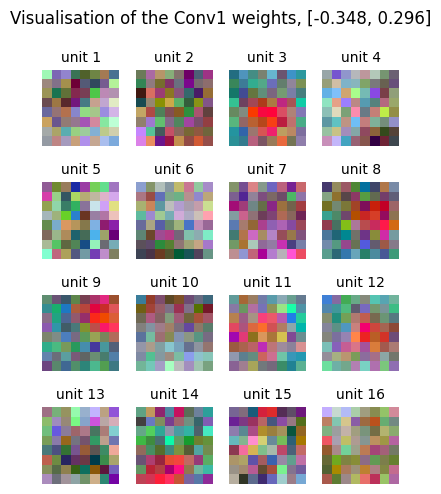

In [36]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=10)
plt.suptitle(f'Visualisation of the Conv1 weights, {[np.round(float(w1.min()), 3), np.round(float(w1.max()), 3)]}')
plt.tight_layout()
plt.gcf().set_size_inches(4, 5)
plt.show()

# Activation Visualisation

In [7]:
# Experiment settings
batch_num = 100
batch_size = 500
dims = [64, 3] # 64 x 64 noise input, 3 channels

net.eval()
hx, cx = torch.zeros((batch_size, 128), dtype=torch.float32), torch.zeros((batch_size, 128), dtype=torch.float32)
X = (torch.rand(batch_size, dims[1], dims[0], dims[0]) - 0.5) * 255 # colored noise pattern ensemble, zero mean
x1,x2,(_,_) = net(0, X, (hx,cx), 1) # forward pass to get the activation map

print(x1.shape)
print(x2.shape)

torch.Size([500, 16, 15, 15])
torch.Size([500, 32, 6, 6])


# Lab Recording Room

Where you collect neural responses

In [42]:
# Experiment settings
batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv2'
dims = [64, 3] # 64 x 64 noise input, 3 channels

# Get centre locations of receptive field to record activation (arbitrary choice)
net.eval()
hx, cx = torch.zeros((batch_size, 128), dtype=torch.float32), torch.zeros((batch_size, 128), dtype=torch.float32)
X = (torch.rand(batch_size, dims[1], dims[0], dims[0]) - 0.5) * 255 # colored noise pattern ensemble, zero mean
x1,x2,(_,_) = net(0, X, (hx,cx), 1) # forward pass to get the activation map
if layer == 'conv1':
    nR,nC = x1[0,0,:,:].shape
elif layer == 'conv2':
    nR,nC = x2[0,0,:,:].shape
print(f'Size of {layer} activation map: ({nR}, {nC})')
locs = [int(round(float(nR)/2.0)), int(round(float(nC)/2.0))] # location of the centre pixel
print(f'r, c centre locations of the receptive fields are ({locs[0]}, {locs[1]})')

# Recording
if layer == 'conv1':
    act_conv1, noise1 = ActRecorder(layer, net, 'jaco', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise1.min(), noise1.max(), noise1.mean()}')
    # Remove biases
    for unit in range(act_conv1.shape[0]):
        act_conv1[unit] -= net.state_dict()['conv1.bias'][unit]
        
elif layer == 'conv2':
    act_conv2, noise2 = ActRecorder(layer, net, 'jaco', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise2.min(), noise2.max(), noise2.mean()}')
    # Remove biases
    for unit in range(act_conv2.shape[0]):
        act_conv2[unit] -= net.state_dict()['conv2.bias'][unit]

Size of conv2 activation map: (6, 6)
r, c centre locations of the receptive fields are (3, 3)


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Activation recording complete.


100%|██████████| 32/32 [00:00<00:00, 270.06it/s]


Shape of activation response list: torch.Size([32, 50000])
Shape of noise list: torch.Size([50000, 64, 64, 3])
min, max and mean of noise: (tensor(-127.5000), tensor(127.5000), tensor(0.0005))


Save the input and output

In [38]:
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

In [39]:
# Conv1
layer = 'conv1'
torch.save(act_conv1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
torch.save(noise1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

In [43]:
# Conv2
layer = 'conv2'
torch.save(act_conv2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
torch.save(noise2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

The noise input follows the requirements of STA - zero mean, symmetric noise distribution for unbiased estimation. \
However, it is important to note that the model never received negative inputs during training (since image data).

In [5]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv1'

# intput & output
act_conv1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# RWA for RF
rf1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
rf_corr1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

# RF cropping
correlation1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')
mi1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')
rf_cropped1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')
noise_cropped1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

# RWC
cov1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

# load eigen1.pkl
with open(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'rb') as f:
    eigen1 = pickle.load(f)

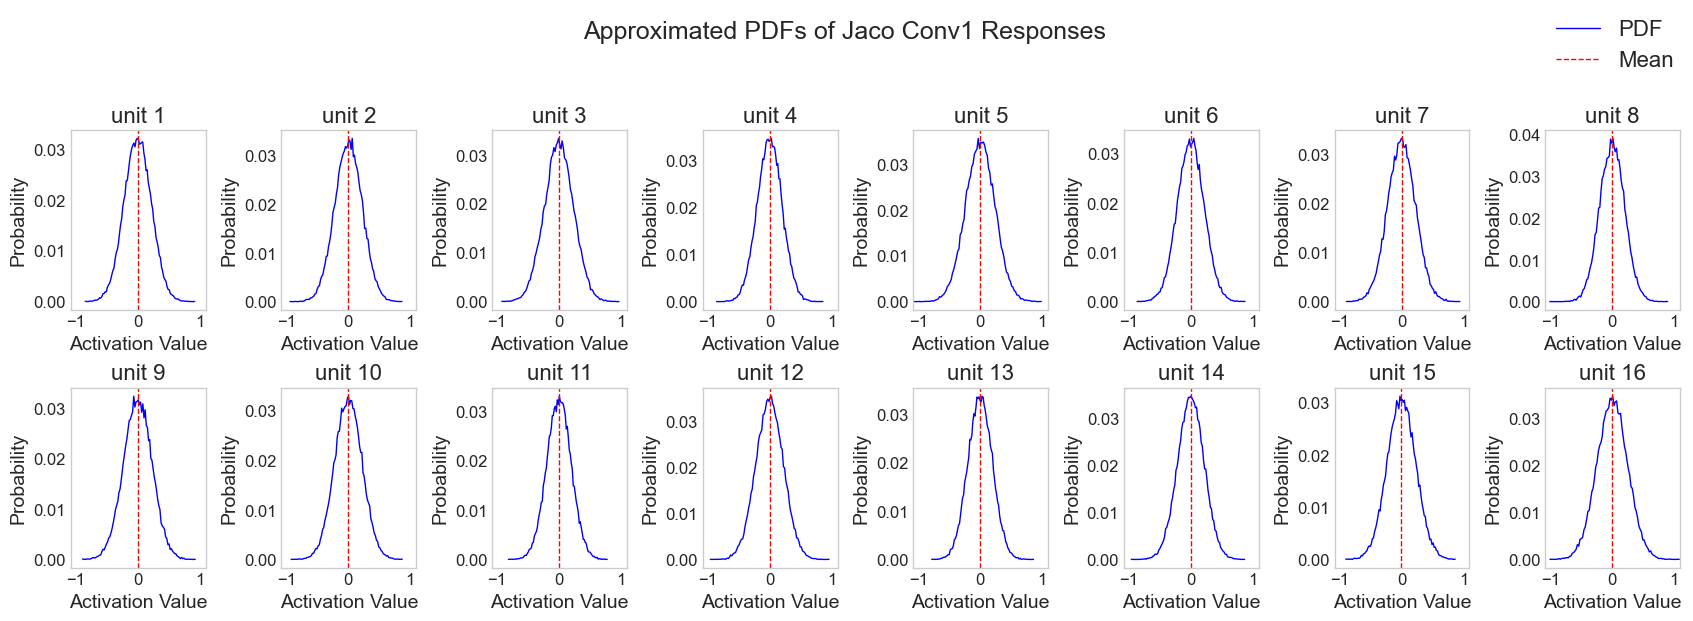

In [10]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 9)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of Jaco Conv1 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 11)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [10]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)
print(rf1.shape)

  0%|          | 0/800000 [00:00<?, ?it/s]

100%|██████████| 800000/800000 [00:30<00:00, 26648.39it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [12]:
# Save the RWA data
torch.save(rf1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-2.414 2.027


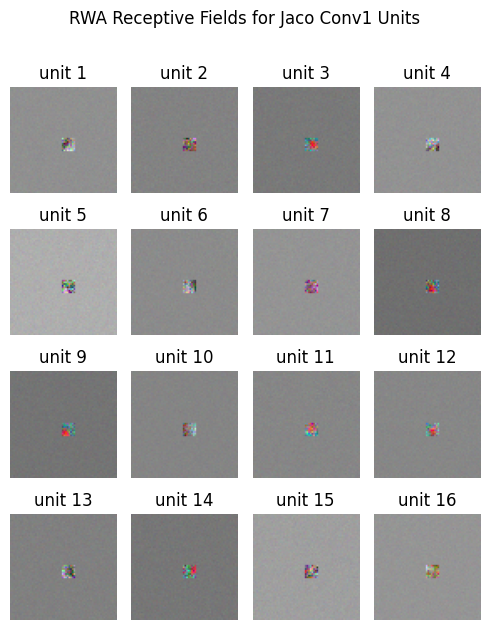

In [11]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for Jaco Conv1 Units', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [15]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 65536/65536 [04:46<00:00, 229.06it/s]


In [16]:
# Save the RWA data
torch.save(rf_corr1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-0.235 0.216


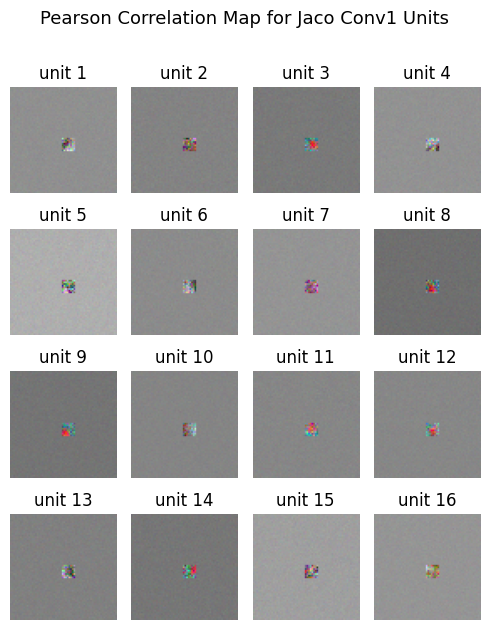

In [12]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for Jaco Conv1 Units', fontsize=13)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask

In [17]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrMask(noise1[:, :, :, i], act_conv1)

100%|██████████| 65536/65536 [06:04<00:00, 179.57it/s]


Text(0.5, 1.0, 'Superposed PCC for Jaco RF Cropping')

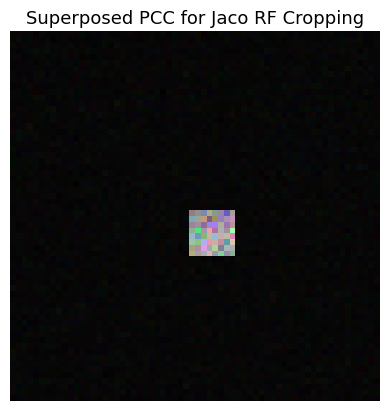

In [13]:
# Display the correlation mask
plt.style.use('default')
to_show = (correlation1 - correlation1.min()) / (correlation1.max() - correlation1.min())
plt.axis('off')
plt.imshow(to_show)
plt.title(f'Superposed PCC for Jaco RF Cropping', fontsize=13)

In [19]:
# save the correlation data
torch.save(correlation1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')

In [14]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

Text(0.5, 1.0, 'Correlation Mask for Jaco RF Cropping')

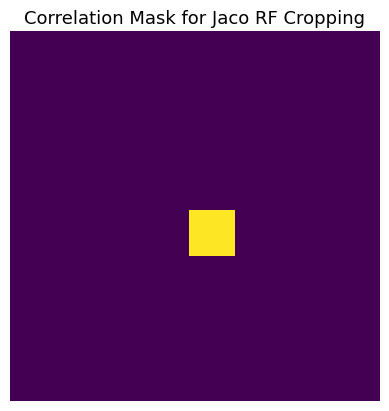

In [15]:
plt.axis('off')

plt.imshow(mask)
plt.title(f'Correlation Mask for Jaco RF Cropping', fontsize=13)

-0.235 0.216


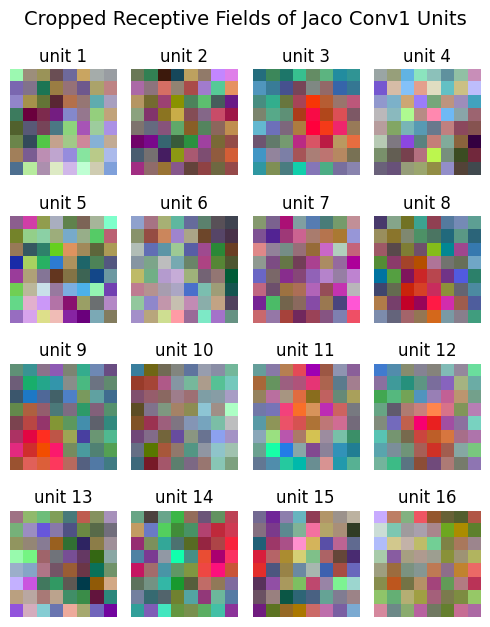

In [16]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of Jaco Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [ ]:
# save the cropped RFs
torch.save(rf_cropped1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Mutual Information

In [18]:
print(noise1[:, 0, 0].flatten().shape) # one pixel noise
print(act_conv1[0].flatten().shape) # one unit activation

torch.Size([150000])
torch.Size([50000])


In [ ]:
num_units = act_conv1.shape[0]
mi1 = torch.zeros((num_units, noise1.shape[1], noise1.shape[2], noise1.shape[3])) # single channel

with tqdm(total = num_units * noise1.shape[1] * noise1.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise1.shape[1]):
            for k in range(noise1.shape[2]): # go through each pixel
                for l in range(noise1.shape[3]):
                    mi1[i, j, k, l] = mutual_info_score(noise1[:, j, k, l].flatten(), act_conv1[i].flatten())
                    pbar.update(1)

In [ ]:
# save the cropped RFs
torch.save(mi1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')

-0.235 0.216


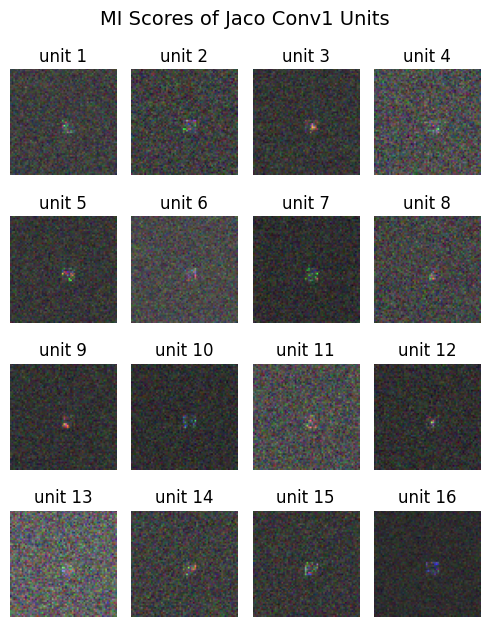

In [22]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'MI Scores of Jaco Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [27]:
correlation1.shape

torch.Size([64, 64, 3])

In [29]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
mi_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], mi1[:, :, :, i]) # crop the RFs
    mi_cropped1.append(tmp)
mi_cropped1 = torch.stack(mi_cropped1, dim=3)

-0.235 0.216


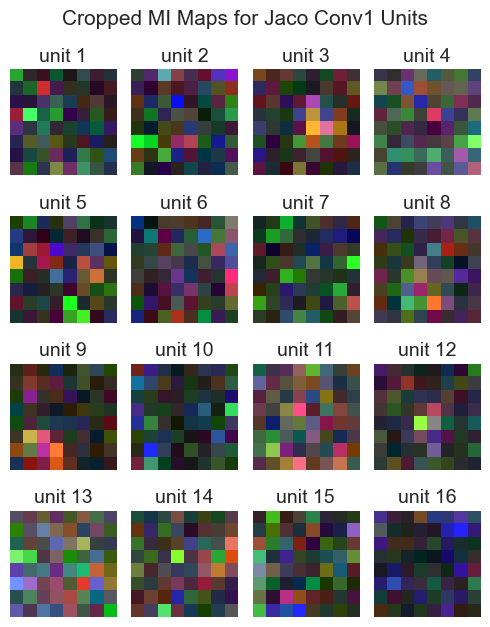

In [49]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi_cropped1[i, :, :, :]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=14)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped MI Maps for Jaco Conv1 Units', fontsize=15)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

Phase-Weighted Analysis

In [30]:
# visualise range of act_conv1
print(act_conv1.min(), act_conv1.max())

tensor(-2.1212) tensor(1.8417)


-0.235 0.216


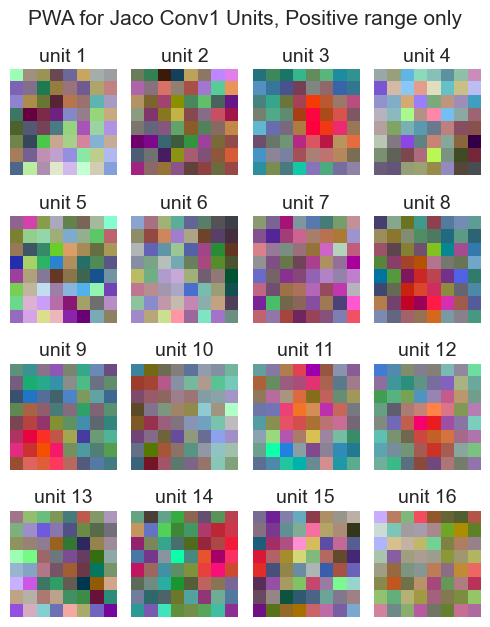

In [48]:
# # select window
# # Only negative
# lower_bound = act_conv1.min()
# upper_bound = 0
## Only positive
lower_bound = 0
upper_bound = act_conv1.max()

# Absolute = False - Visualise the RWA output as image plots
for unit in range(rf1.shape[0]):
    plt.subplot(4, 4, unit+1) # nrows, ncols, index
    plt.axis('off')
    
    # if the unit is not dead (positive activation values)
    if act_conv1[unit][act_conv1[unit] > 0].shape[0] != 0: # negative activation values are dead units
        windowed_rf = torch.zeros(rf_cropped1[unit].shape)
        noise_windowed = torch.zeros(noise_cropped1.shape)

        # select relevant noise inputs corresponding to the activations within the range
        count = 0
        for i in range(act_conv1.shape[1]):
            if (act_conv1[unit][i] > lower_bound) and (act_conv1[unit][i] < upper_bound):
                noise_windowed[i] = noise_cropped1[i]
                count += 1
        
        # absolute RWA
        for i in range(noise_windowed.shape[0]):
            windowed_rf += abs(act_conv1[unit, i]) * noise_windowed[i]
        # normalise windowed_rf by the number of elements 
        windowed_rf = windowed_rf / count

        # plot the windowed RF
        to_show = (windowed_rf - windowed_rf.min())/(windowed_rf.max()-windowed_rf.min())
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(unit+1)}', fontsize=14)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'PWA for Jaco Conv1 Units, Positive range only', fontsize=15)
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

-0.235 0.216


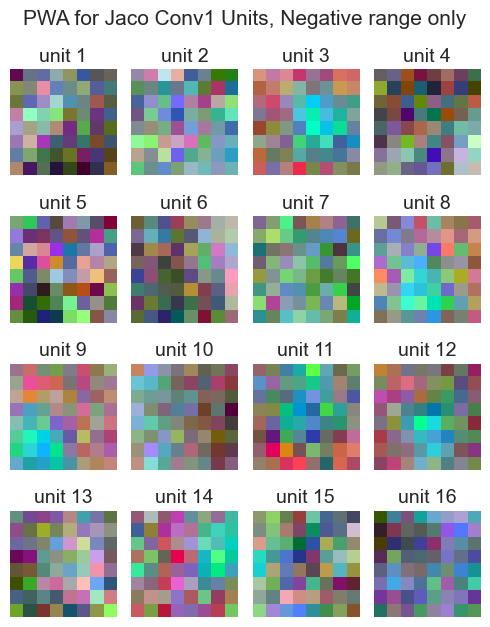

In [50]:
# # select window
# Only negative
lower_bound = act_conv1.min()
upper_bound = 0
## Only positive
# lower_bound = 0
# upper_bound = act_conv1.max()

# Absolute = False - Visualise the RWA output as image plots
for unit in range(rf1.shape[0]):
    plt.subplot(4, 4, unit+1) # nrows, ncols, index
    plt.axis('off')
    
    # if the unit is not dead (positive activation values)
    if act_conv1[unit][act_conv1[unit] > 0].shape[0] != 0: # negative activation values are dead units
        windowed_rf = torch.zeros(rf_cropped1[unit].shape)
        noise_windowed = torch.zeros(noise_cropped1.shape)

        # select relevant noise inputs corresponding to the activations within the range
        count = 0
        for i in range(act_conv1.shape[1]):
            if (act_conv1[unit][i] > lower_bound) and (act_conv1[unit][i] < upper_bound):
                noise_windowed[i] = noise_cropped1[i]
                count += 1
        
        # absolute RWA
        for i in range(noise_windowed.shape[0]):
            windowed_rf += abs(act_conv1[unit, i]) * noise_windowed[i]
        # normalise windowed_rf by the number of elements 
        windowed_rf = windowed_rf / count

        # plot the windowed RF
        to_show = (windowed_rf - windowed_rf.min())/(windowed_rf.max()-windowed_rf.min())
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(unit+1)}', fontsize=14)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'PWA for Jaco Conv1 Units, Negative range only', fontsize=15)
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

Response-Weighted Covariance - Normal RWA

In [ ]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

In [ ]:
torch.save(noise_cropped1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [37]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [04:14<00:00, 3142.88it/s]


In [38]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov1: {cov1.shape}")

Shape of mu: torch.Size([16, 50000, 192])
Shape of cov1: torch.Size([16, 192, 192])


In [39]:
# save the pca covariance data
torch.save(cov1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [40]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

In [41]:
# Store the eigenvalues and eigenvectors
eigen1 = (eigenvectors1, eigenvalues1)
with open(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

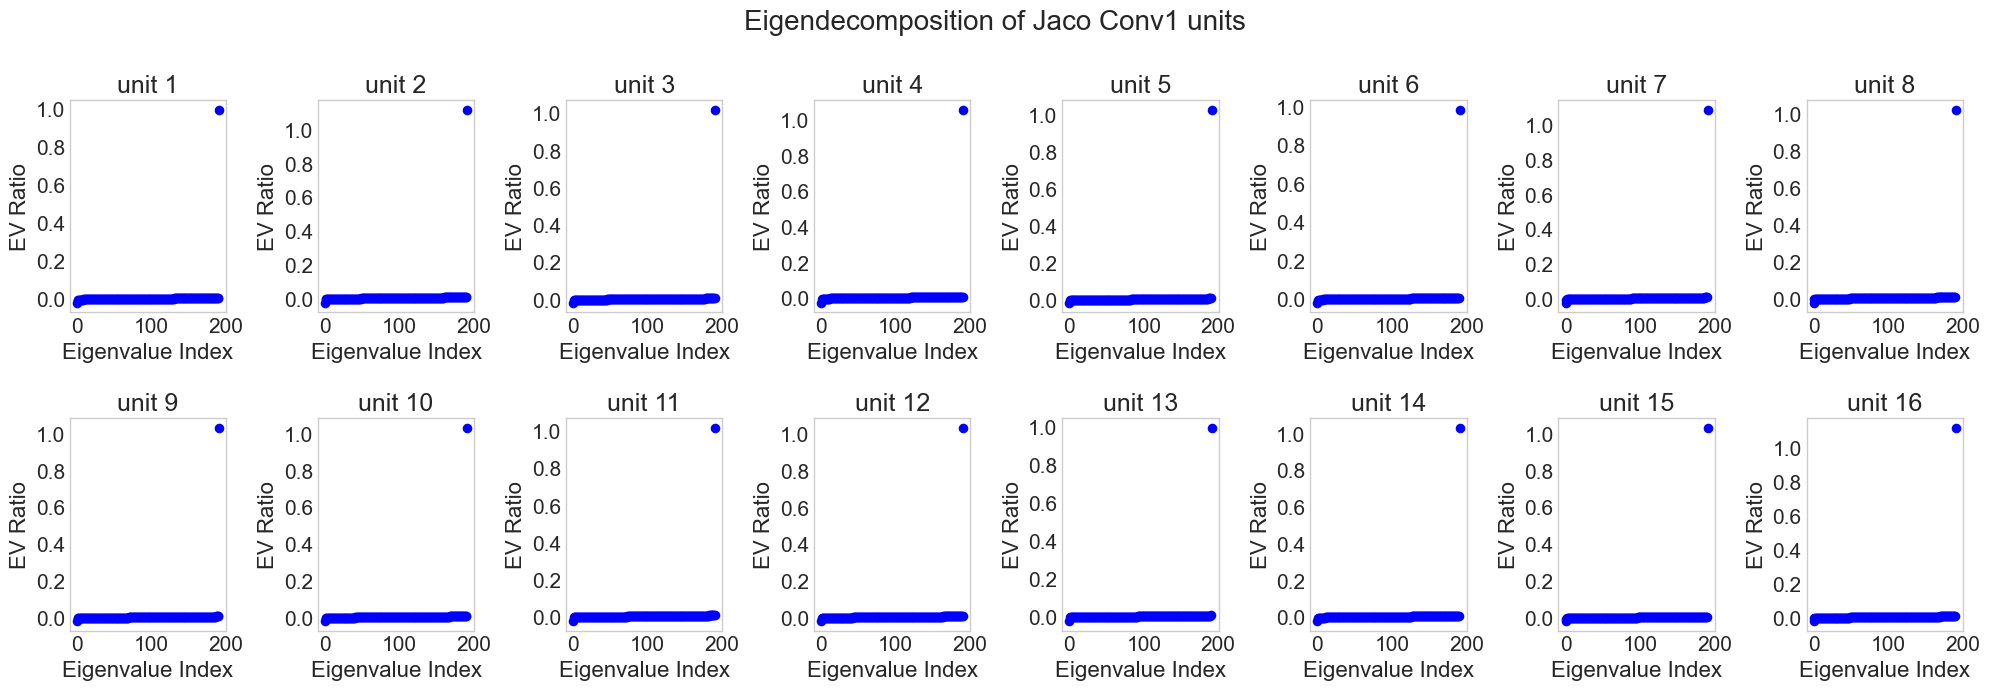

In [52]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    y = eigenvalues1[i]
    # reverse the order of the eigenvalues
    y = -1*y.flip(0)
    y /= y.sum()
    plt.scatter(range(len(eigenvalues1[i])), y, s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of Jaco Conv1 units', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.235 0.216


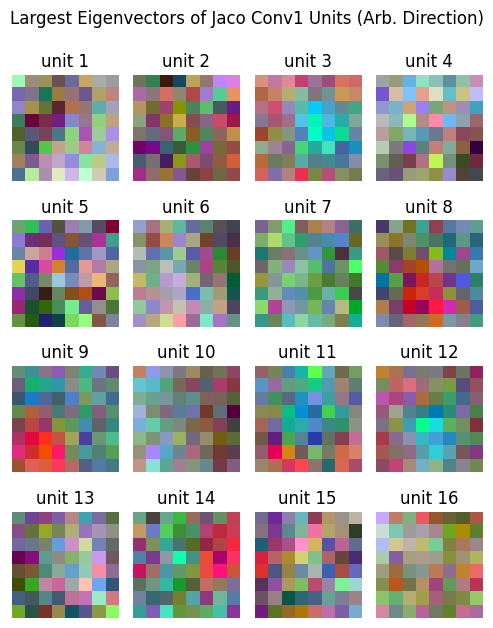

In [53]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of Jaco Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Grpahical Representation

In [54]:
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

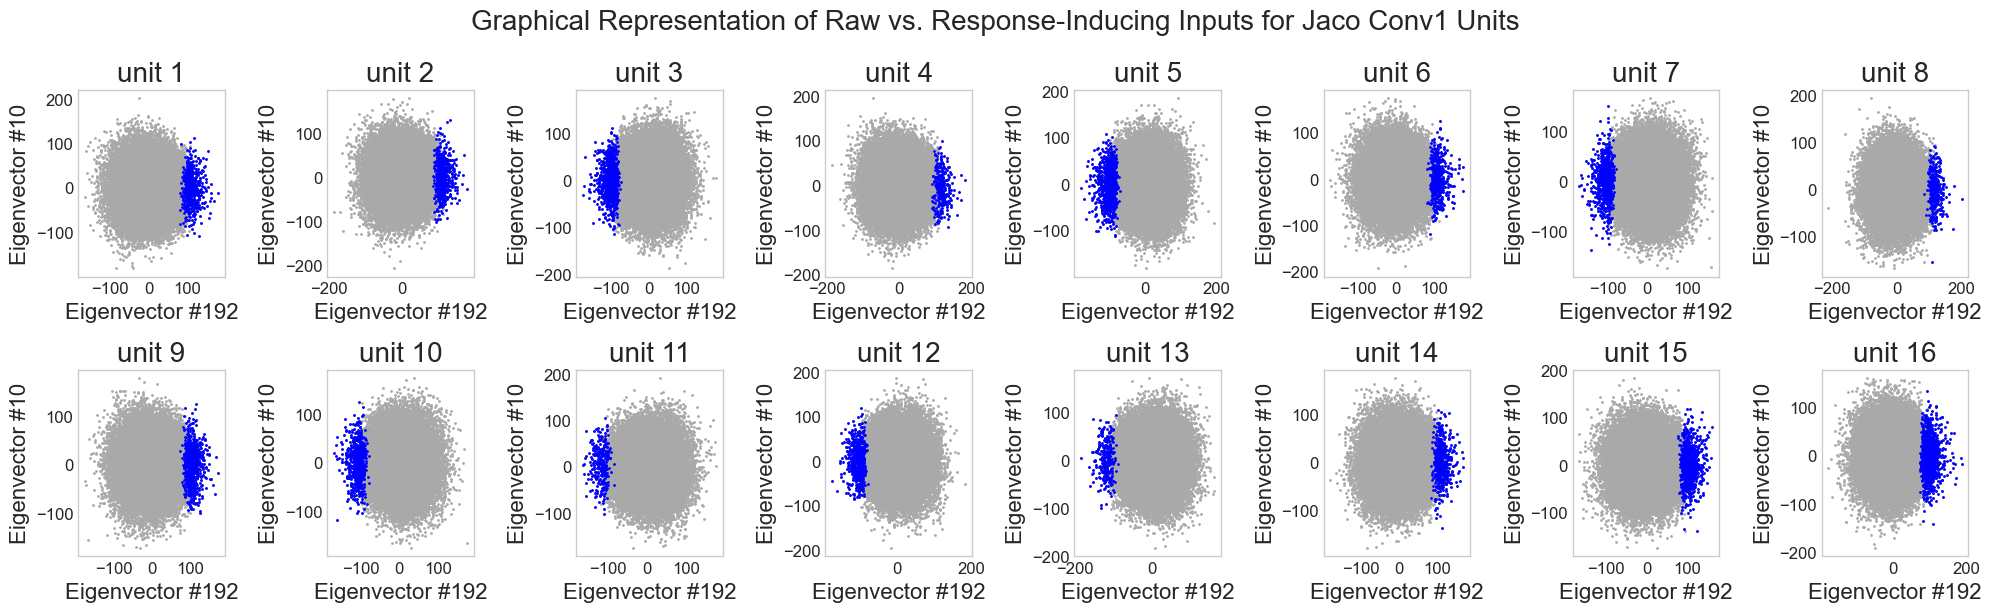

In [63]:
# PCA space
threshold = 0.5 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = eigenvectors1[unit, :, 0] # max component for the unit
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Eigenvector #192', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=20)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for Jaco Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

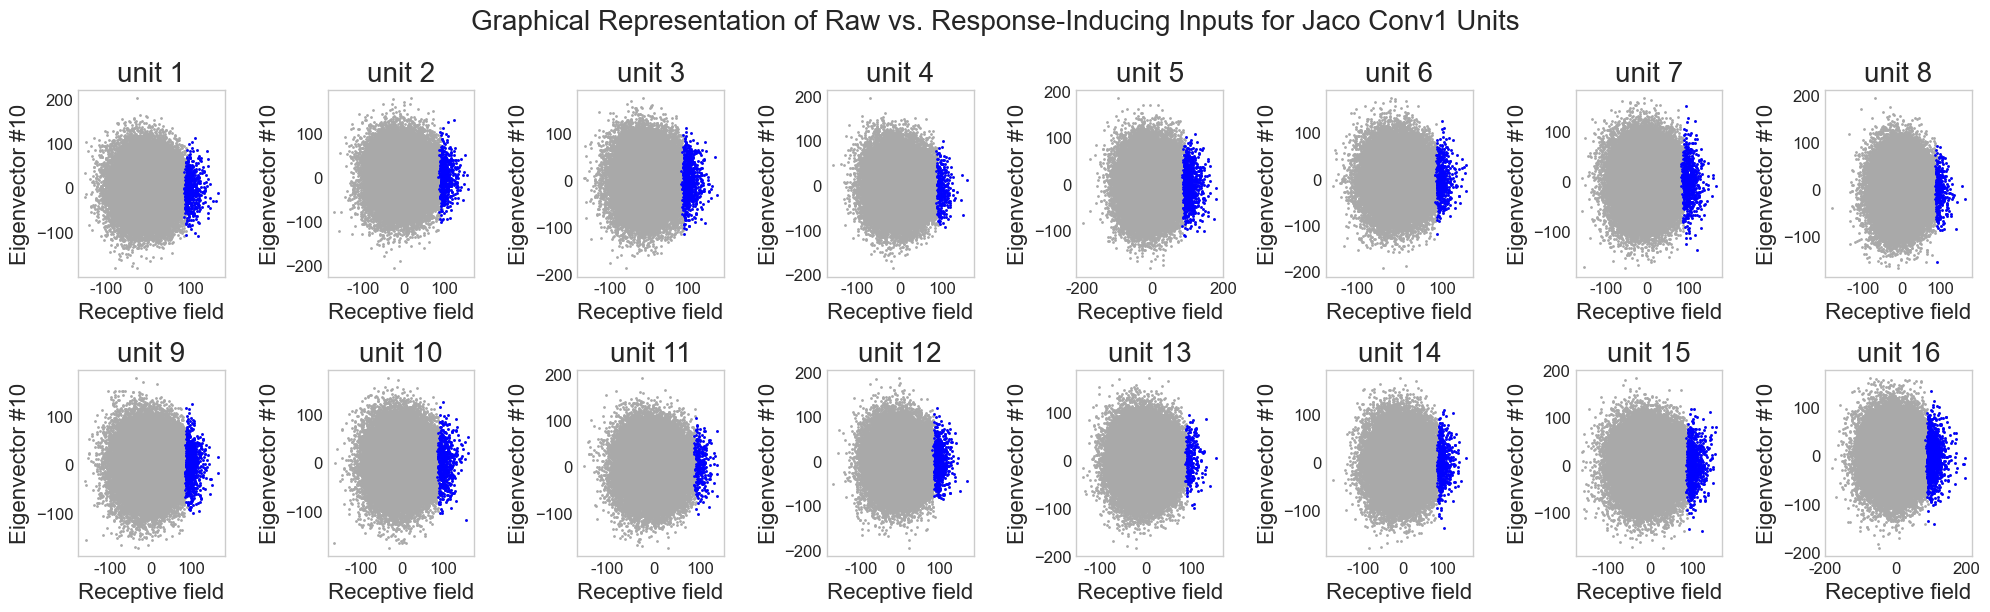

In [64]:
# RF space
threshold = 0.5 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = rf_cropped_flat1[unit]
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Receptive field', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=20)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)
    
    # divide x axis by 1000
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/10)))

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for Jaco Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

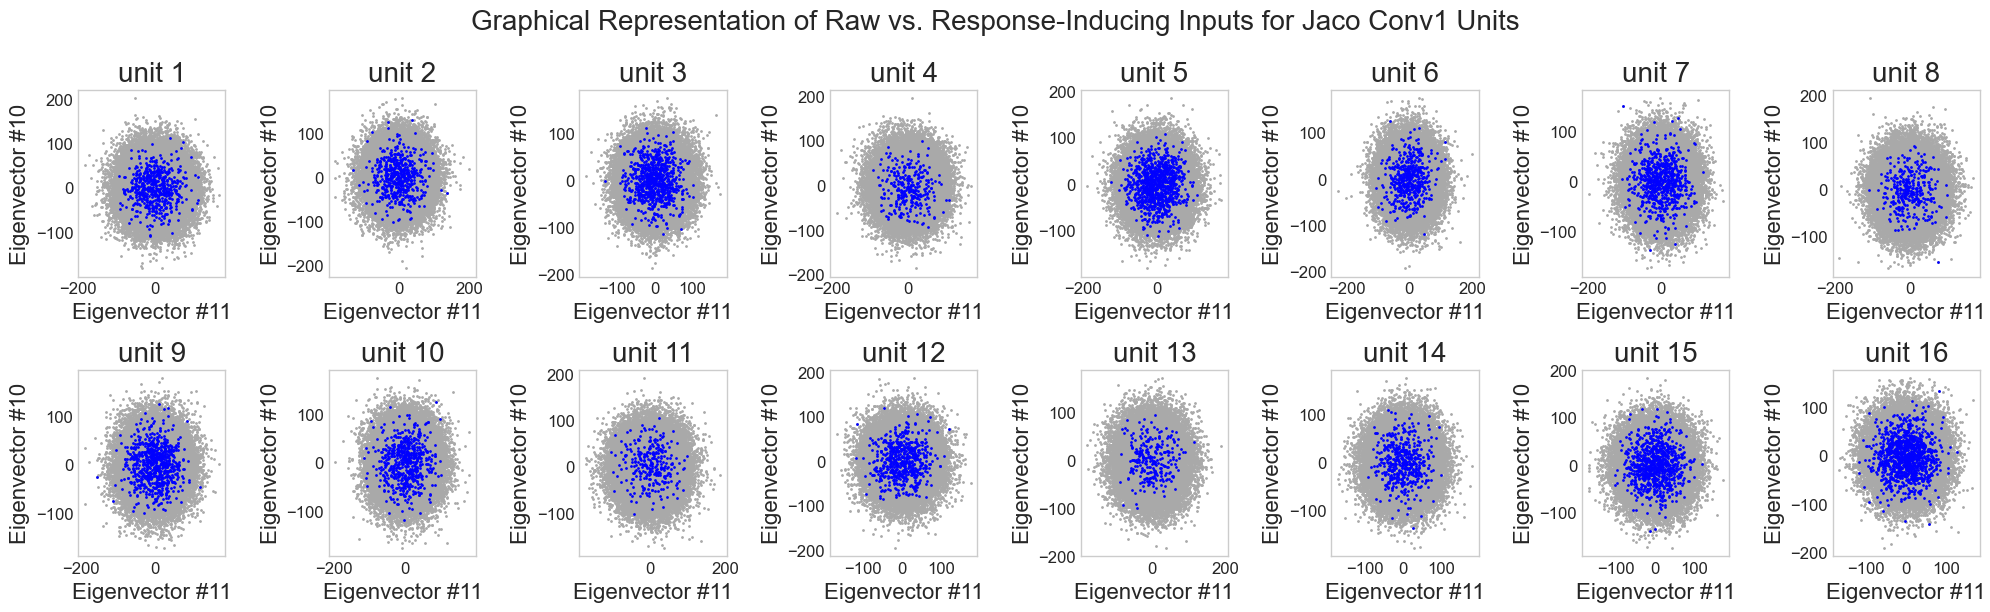

In [65]:
# noise space
threshold = 0.5 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = eigenvectors1[unit, :, 11]
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Eigenvector #11', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=20)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)
    
    # divide x axis by 1000
    # plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/1000)))

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for Jaco Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

In [60]:
mi_cropped_flat1 = mi_cropped1.view(mi_cropped1.shape[0], -1)
mi_cropped_flat1.shape

torch.Size([16, 192])

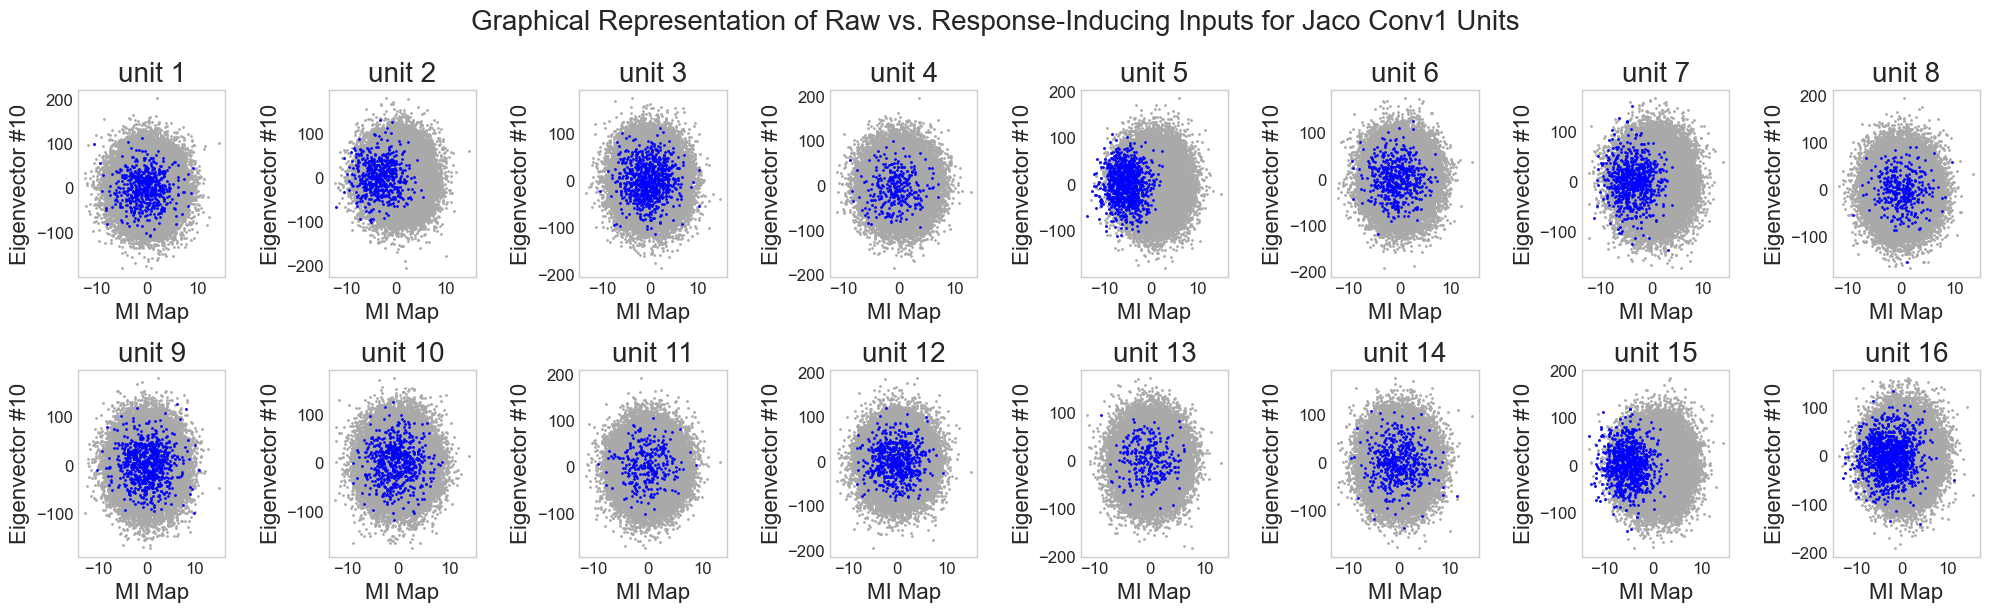

In [66]:
# mi space
threshold = 0.5 # threshold for activation
plt.style.use('seaborn-v0_8-whitegrid')

for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    
    stixel1 = mi_cropped_flat1[unit]
    stixel2 = eigenvectors1[unit, :, 10] # arbitrary component for the unit

    # Project noise onto the principal components
    proj1 = noise_cropped_flat1 @ stixel1
    proj2 = noise_cropped_flat1 @ stixel2

    # Plot the stixel 1 against stixel 2 for the noise inputs
    plt.scatter(proj1, proj2, s=1, c='darkgray')

    # Stimulating noise inputs
    stimulate_cropped_flat1 = torch.zeros(noise_cropped_flat1.shape) # store the response-stimulating noise inputs
    for i in range(noise_cropped_flat1.shape[0]):
        if act_conv1[unit][i] > threshold:
            stimulate_cropped_flat1[i] = noise_cropped_flat1[i]
    stimulate_cropped_flat1 = stimulate_cropped_flat1[~torch.all(stimulate_cropped_flat1 == 0, dim=1)] # Remove zero components

    # Project stimulating noise onto the principal components
    proj1 = stimulate_cropped_flat1 @ stixel1
    proj2 = stimulate_cropped_flat1 @ stixel2
    
    # turn off grid
    plt.grid(False)
    
    # PLotting
    # set x tick and y tick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('MI Map', fontsize=16)
    plt.ylabel('Eigenvector #10', fontsize=16)
    plt.title(f'unit {unit+1}', fontsize=20)
    plt.scatter(proj1, proj2, s=1, c='blue')
    plt.gcf().set_size_inches(5, 5)

# specify spacing between subplots without using tight_layout
plt.suptitle(f'Graphical Representation of Raw vs. Response-Inducing Inputs for Jaco Conv1 Units', fontsize=20) 
plt.gcf().set_size_inches(20, 6.2)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plt.show()

Absolute RWA

In [6]:
# RWA
rf1 = RWA(act_conv1, noise1, absolute=True)
print(rf1.shape)

100%|██████████| 800000/800000 [00:38<00:00, 20693.26it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])
torch.Size([16, 64, 64, 3])


-0.187 0.177


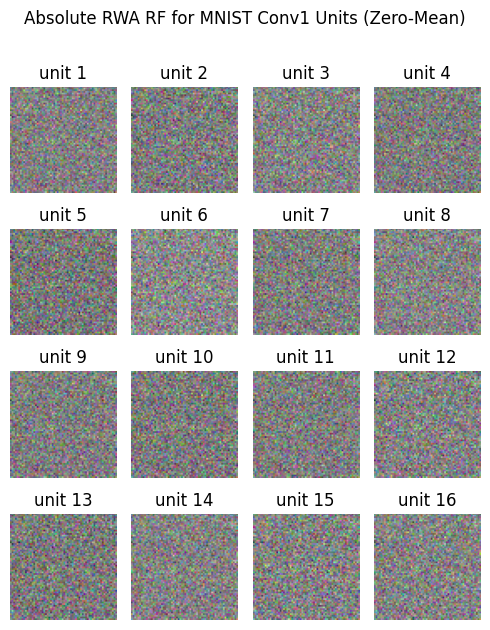

In [7]:
# Absolute = True - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Absolute RWA RF for MNIST Conv1 Units (Zero-Mean)', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [8]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

RWC

In [9]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 8, 8, 3])


In [10]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [04:46<00:00, 2795.62it/s]


In [25]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

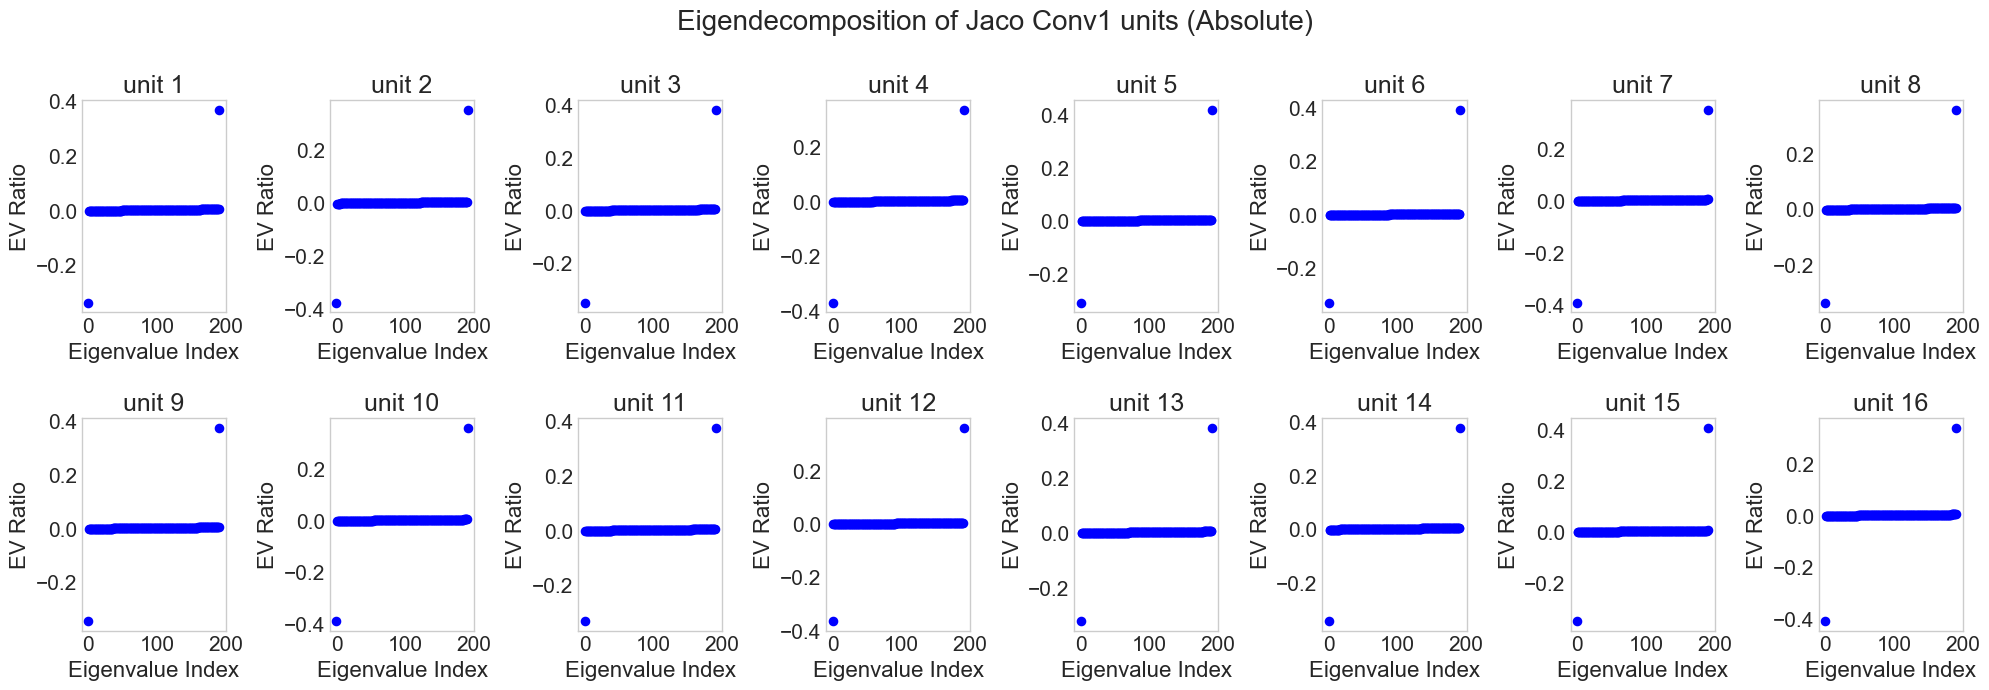

In [26]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    y = eigenvalues1[i]
    # reverse the order of the eigenvalues
    # y = -1*y.flip(0)
    y /= abs(y).sum()
    
    plt.scatter(range(len(eigenvalues1[i])), y, s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of Jaco Conv1 units (Absolute)', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.235 0.216


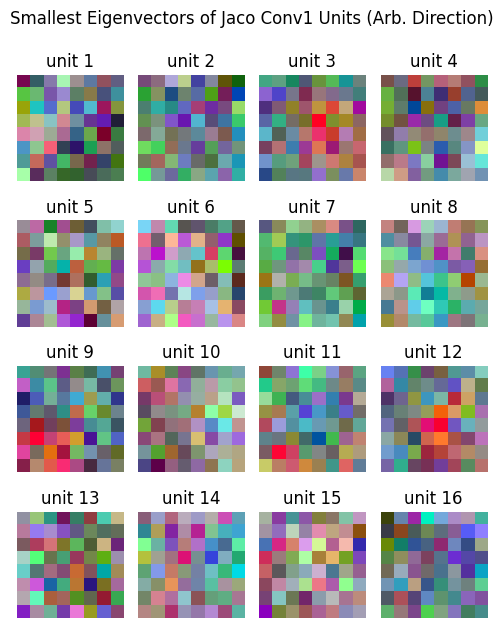

In [28]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of Jaco Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

-0.235 0.216


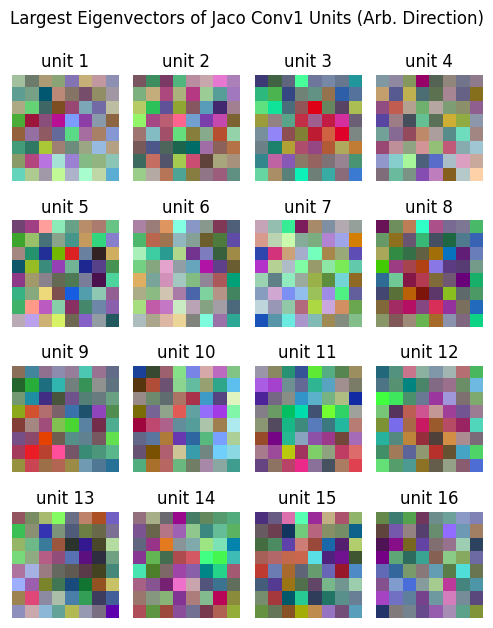

In [29]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, -1].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of Jaco Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Conv1 - Positive Only [0, 255]


In [ ]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = False
layer = 'conv1'

# intput & output
act_conv1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# RWA for RF
rf1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
rf_corr1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

# RF cropping
correlation1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')
mi1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')
rf_cropped1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')
noise_cropped1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

# RWC
cov1 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

# load eigen1.pkl
with open(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'rb') as f:
    eigen1 = pickle.load(f)

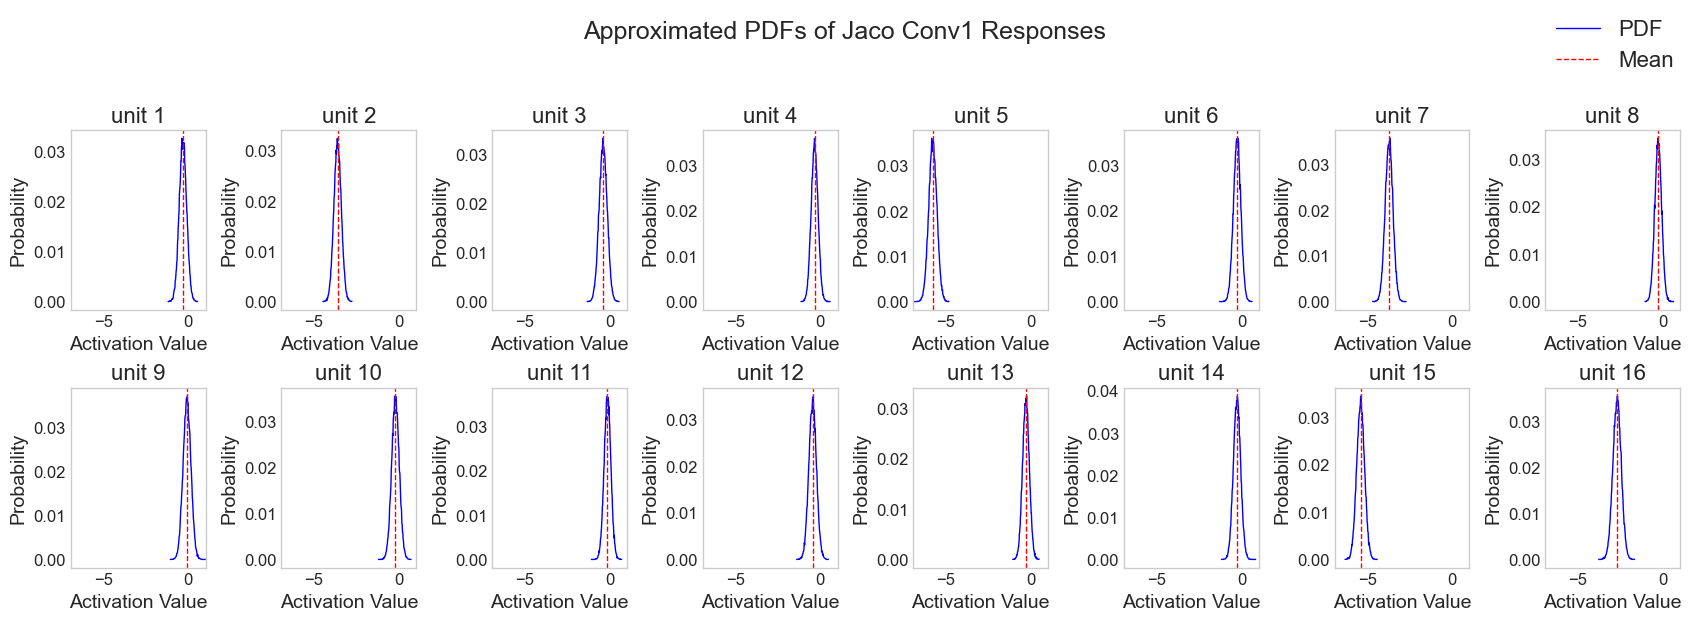

In [45]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 9)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of Jaco Conv1 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 11)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [46]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)
print(rf1.shape)

100%|██████████| 800000/800000 [00:38<00:00, 20908.42it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])
torch.Size([16, 64, 64, 3])


In [47]:
# Save the RWA data
torch.save(rf1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-739.67 -7.737


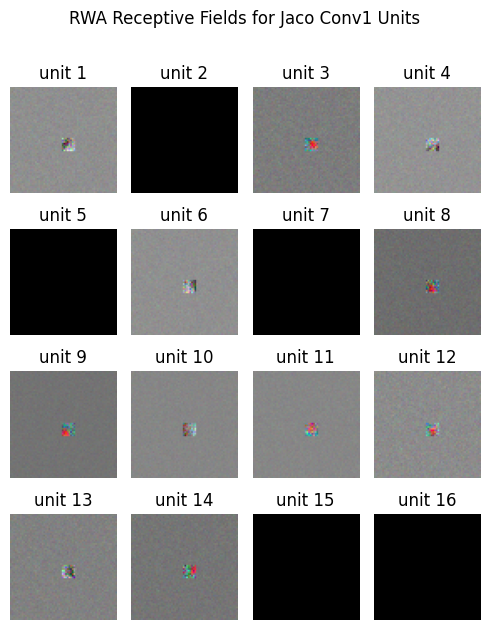

In [48]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for Jaco Conv1 Units', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [49]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

In [50]:
# save the cropped RFs
torch.save(rf_cropped1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Response-Weighted Covariance - Normal RWA

In [51]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 8, 8, 3])


In [52]:
torch.save(noise_cropped1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [53]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [04:41<00:00, 2842.35it/s]


In [54]:
# save the pca covariance data
torch.save(cov1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [59]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

In [56]:
# Store the eigenvalues and eigenvectors
eigen1 = (eigenvectors1, eigenvalues1)
with open(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

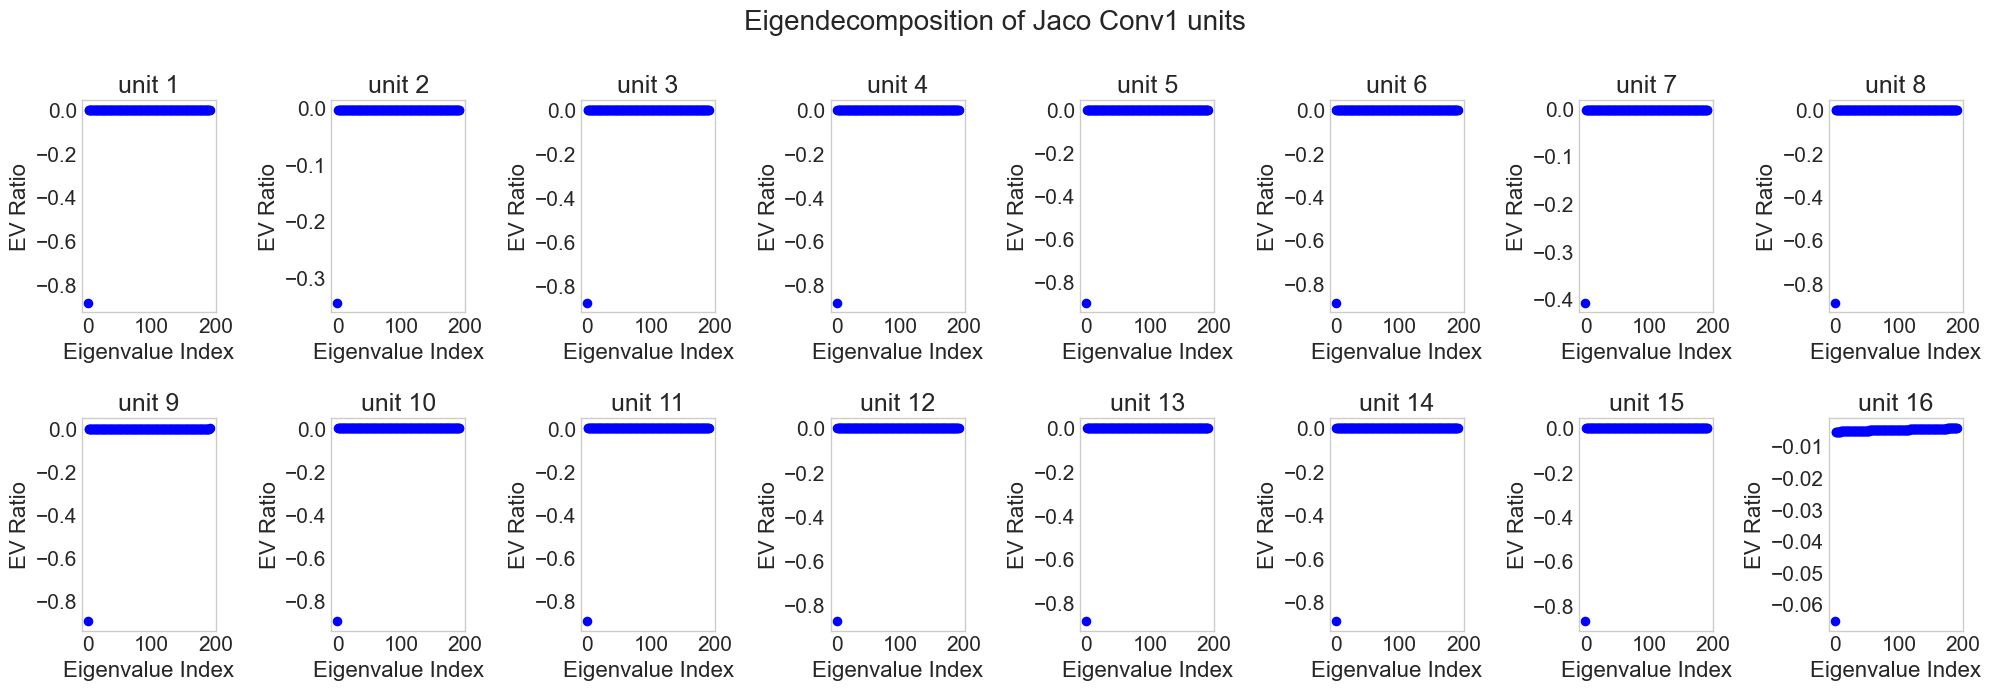

In [61]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    y = eigenvalues1[i]
    # # reverse the order of the eigenvalues
    # y = -1*y.flip(0)
    y /= abs(y).sum()
    plt.scatter(range(len(eigenvalues1[i])), y, s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of Jaco Conv1 units', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.235 0.216


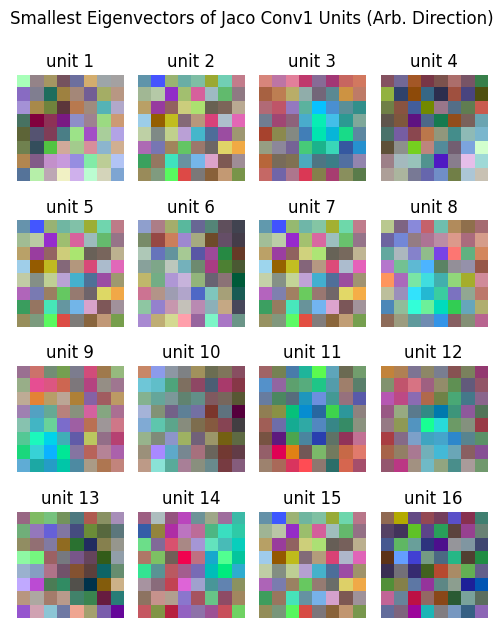

In [64]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, -1].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of Jaco Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

-0.235 0.216


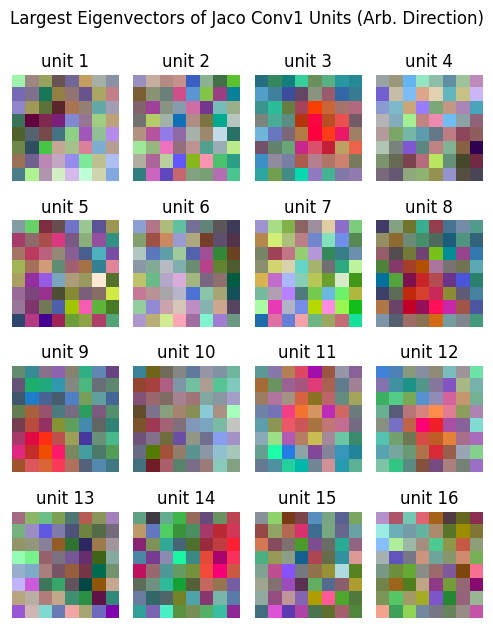

In [66]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of Jaco Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]

In [68]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv2'

# intput & output
act_conv2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# # RWA for RF
# rf2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
# rf_corr2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

# # RF cropping
# correlation2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')
# mi2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')
# rf_cropped2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')
# noise_cropped2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

# # RWC
# cov2 = torch.load(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

# # load eigen2.pkl
# with open(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'rb') as f:
#     eigen2 = pickle.load(f)

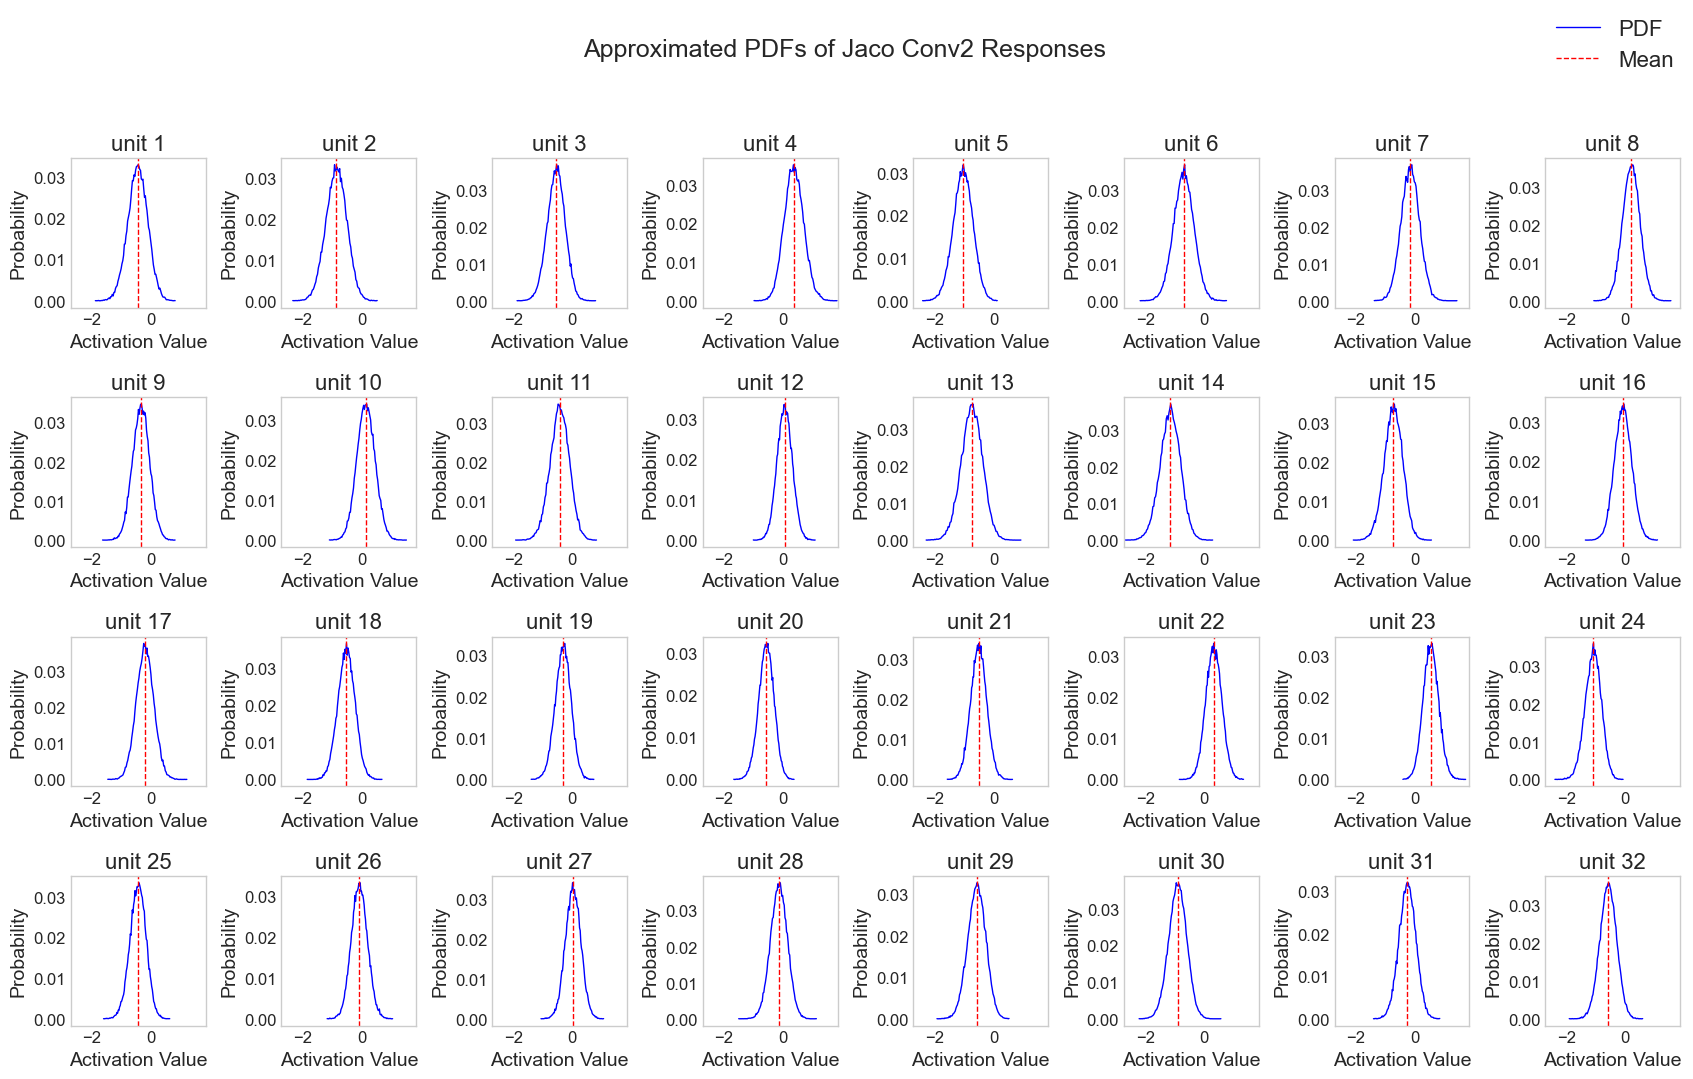

In [71]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 17)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of Jaco Conv2 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 20)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.92)
plt.subplots_adjust(hspace=0.6)
plt.show()

RWA

In [70]:
# RWA - unbiased RF estimation, absolute false
rf2 = RWA(act_conv2, noise2, absolute=False)
print(rf2.shape)

100%|██████████| 1600000/1600000 [01:07<00:00, 23638.20it/s]


Shape of receptive field list: torch.Size([32, 64, 64, 3])
torch.Size([32, 64, 64, 3])


In [72]:
# Save the RWA data
torch.save(rf2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')

-1.514 1.709


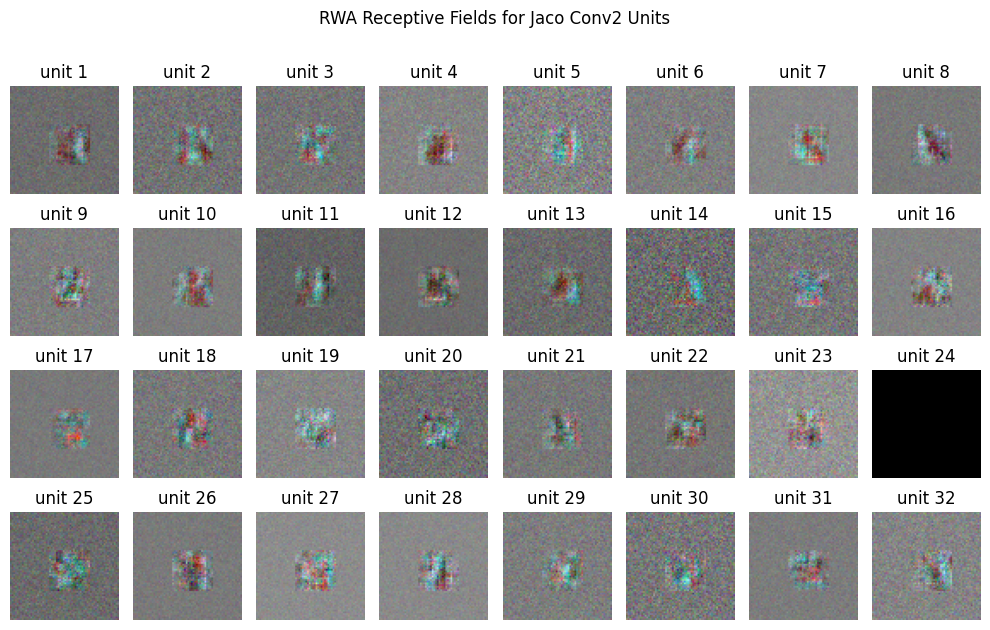

In [73]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for Jaco Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [74]:
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]): # loop through each channel
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

100%|██████████| 131072/131072 [04:41<00:00, 465.31it/s]


In [75]:
# Save the RWA data
torch.save(rf_corr2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-1.514 1.709


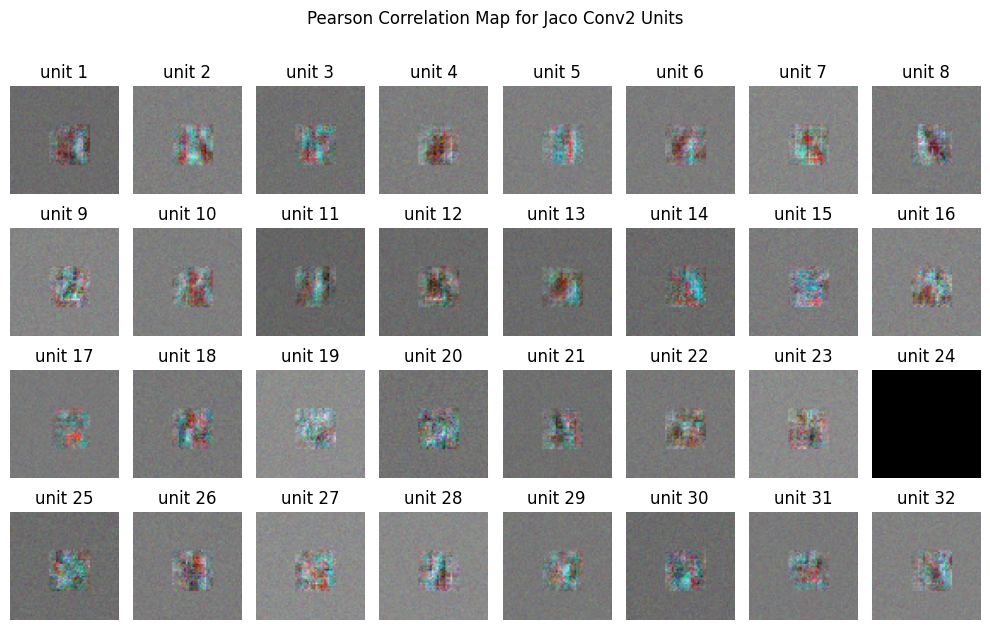

In [76]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for Jaco Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask


In [78]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation2 = torch.zeros(rf2.shape[1], rf2.shape[2], rf2.shape[3])
for i in range(rf2.shape[3]):
    correlation2[:, :, i] = CorrMask(noise2[:, :, :, i], act_conv2)

 25%|██▌       | 33039/131072 [00:56<02:46, 587.43it/s]

In [ ]:
# Display the correlation mask
plt.style.use('default')
to_show = (correlation2 - correlation2.min()) / (correlation2.max() - correlation2.min())
plt.axis('off')
plt.imshow(to_show)
plt.title(f'Superposed PCC for Jaco RF Cropping', fontsize=13)

In [ ]:
# save the correlation data
torch.save(correlation2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')

In [ ]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
rf_cropped2 = []
for i in range(rf2.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation2[:, :, i], rf2[:, :, :, i]) # crop the RFs
    rf_cropped2.append(tmp)
rf_cropped2 = torch.stack(rf_cropped2, dim=3)

NameError: name 'correlation2' is not defined

In [ ]:
plt.axis('off')

plt.imshow(mask)
plt.title(f'Correlation Mask for Jaco RF Cropping', fontsize=13)

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of Jaco Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# save the cropped RFs
torch.save(rf_cropped2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Mutual Information

In [ ]:
# round every number in noise1 to nearest whole number
noise2_ = np.round(noise2)
act_conv2_ = np.round(act_conv2)

In [ ]:
num_units = act_conv2.shape[0]
mi2 = torch.zeros((num_units, noise2.shape[1], noise2.shape[2])) # single channel

with tqdm(total = num_units * noise2.shape[1] * noise2.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise2.shape[1]):
            for k in range(noise2.shape[2]): # go through each pixel
                for l in range(num_units):
                    mi2[i, j, k, l] = mutual_info_score(noise2_[:, j, k, l].flatten(), act_conv2_[i].flatten())
                    pbar.update(1)

In [ ]:
# save the cropped RFs
torch.save(mi2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'MI Scores of Jaco Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# crop the RFs
# Threshold for cropping automatically set at 0.01
mi_cropped2, _ = RfCrop(correlation2[:, :, 0], mi2[:, :, :]) # crop the RFs

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Cropped MI Maps for Jaco Conv2 Units', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Response-Weighted Covariance - Normal RWA

In [ ]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped2 = torch.zeros(noise2.shape[0], rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
for i in range(noise_cropped2.shape[3]):
    tmp, _ = RfCrop(correlation2[:, :, i], noise2[:, :, :, i])
    noise_cropped2[:, :, :, i] = tmp
print(noise_cropped2.shape)

In [ ]:
torch.save(noise_cropped2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [ ]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat2 = noise_cropped2.view(noise_cropped2.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat2 = rf_cropped2.view(rf_cropped2.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat2 - rf_cropped_flat2.min()) / (rf_cropped_flat2.max() - rf_cropped_flat2.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat2 - rf_cropped_flat2.min()) / (rf_cropped_flat2.max() - rf_cropped_flat2.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat2.shape[0], noise_cropped_flat2.shape[0], noise_cropped_flat2.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat2 - rf[i]

# RWC
cov2 = RWC(act_conv2, mu)

In [ ]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov2: {cov2.shape}")

In [ ]:
# save the pca covariance data
torch.save(cov2, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [ ]:
# Principal Component Analysis
eigenvalues2 = torch.zeros(cov2.shape[0], cov2.shape[1])
eigenvectors2 = torch.zeros((cov2.shape[0], cov2.shape[1], cov2.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov2.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov2[i])
    eigenvectors2[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues2[i] = torch.tensor(eigen.eigenvalues)

In [ ]:
# Store the eigenvalues and eigenvectors
eigen2 = (eigenvectors2, eigenvalues2)
with open(f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen2, f)

In [ ]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov2.shape[0]):
    plt.subplot(4, 8, i+1)
    y = eigenvalues2[i]
    # reverse the order of the eigenvalues
    plt.scatter(range(len(eigenvalues2[i])), y/abs(y).sum(), s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 10)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of Jaco Conv2 units', fontsize=20) 
plt.gcf().set_size_inches(20, 15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors2[i, :, 0].reshape(rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of MNIST Conv2 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors2[i, :, -1].reshape(rf_cropped2.shape[1], rf_cropped2.shape[2], rf_cropped2.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of MNIST Conv2 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf2.min()), 3), np.round(float(rf2.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(10, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()